Data Gathering and Filtering

In [ ]:

import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.svm import SVC
import seaborn as sns
from wordcloud import WordCloud
from langdetect import detect
import tensorflow as tf
from collections import Counter
drive.mount('/content/drive')


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Set of stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
def filtered_accounts(file_path):
    df = pd.read_json(file_path)
     # Limit the number of tweets per user
    df['tweet'] = df['tweet'].apply(lambda tweets: tweets[:20] if isinstance(tweets, list) else tweets)

    df = filter_english_accounts(df, tweets_column='tweet', min_english_ratio=0.7)
    return df


In [ ]:
test=filtered_accounts('/content/drive/MyDrive/Social Bot detection/Twibot/test.json')
dev=filtered_accounts('/content/drive/MyDrive/Social Bot detection/Twibot/dev.json')
train=filtered_accounts('/content/drive/MyDrive/Social Bot detection/Twibot/train.json')

Analyzing tweets for language detection...
Found 1858 accounts with at least 70.0% English tweets
Analyzing tweets for language detection...
Found 6636 accounts with at least 70.0% English tweets


In [ ]:
test.to_json('/content/drive/MyDrive/Social Bot detection/Twibot/test_english.json')
dev.to_json('/content/drive/MyDrive/Social Bot detection/Twibot/dev_english.json')
train.to_json('/content/drive/MyDrive/Social Bot detection/Twibot/train_english.json')

In [ ]:
def detect_language_safe(text):
    try:
        if pd.isna(text) or str(text).strip() == '':
            return None
        return detect(str(text))
    except:
        return None

def filter_english_accounts(df, tweets_column='tweet', min_english_ratio=0.7):
    filtered_df = df.copy()

    def analyze_user_tweets(tweets):
        # Ensure tweets is a list
        if not isinstance(tweets, list):
            return 0

        # Detect language for each tweet
        languages = [detect_language_safe(tweet) for tweet in tweets if tweet]
        languages = [lang for lang in languages if lang]  # Remove None values

        # Calculate ratio of English tweets
        if not languages:
            return 0
        lang_counts = Counter(languages)
        english_ratio = lang_counts.get('en', 0) / len(languages)

        return english_ratio

    # Calculate English ratio for each user
    print("Analyzing tweets for language detection...")
    filtered_df['english_ratio'] = filtered_df[tweets_column].apply(analyze_user_tweets)

    # Filter users based on minimum English ratio
    english_accounts = filtered_df[filtered_df['english_ratio'] >= min_english_ratio]

    # Drop the temporary column if not needed
    english_accounts = english_accounts.drop('english_ratio', axis=1)

    print(f"Found {len(english_accounts)} accounts with at least {min_english_ratio*100}% English tweets")
    return english_accounts


In [ ]:
def process_twitter_data(file_path):
    df = pd.read_json(file_path)
    threshold = 0.8 * len(df)
    df = df.dropna(thresh=threshold, axis=1)
    df=df.drop(columns=['neighbor'],axis=1)

    columns_to_drop = ['id','id_str', 'name', 'location', 'profile_location','id',
                      'entities', 'url', 'utc_offset', 'time_zone',
                      'contributors_enabled', 'is_translator', 'is_translation_enabled',
                        'profile_background_color', 'profile_background_image_url',
                        'utc_offset', 'time_zone','lang','geo_enabled',
                        'profile_background_image_url_https', 'profile_background_tile',
                        'profile_image_url', 'profile_image_url_https','profile_background_image_url_https',
                        'profile_link_color','profile_sidebar_border_color', 'profile_sidebar_fill_color',
                        'profile_text_color', 'profile_use_background_image', 'has_extended_profile',
                      'default_profile', 'default_profile_image']

    df['profile'] = df['profile'].apply(lambda x: {k: v for k, v in x.items() if k not in columns_to_drop})




    # Process tweet text
    if 'tweet' in df.columns:
      tweet_features = df['tweet'].apply(analyze_tweet_content)
      df = pd.concat([df, tweet_features], axis=1)
      df['processed_tweet'] = df['tweet'].apply(lambda tweets: [preprocess_text(tweet) for tweet in tweets] if isinstance(tweets, list) else preprocess_text(tweets))

      df = df.drop(columns=['tweet','domain'])
      df = df.drop_duplicates(subset='processed_tweet')

    # Extract features
    df = extract_features(df)
    df = df.dropna(axis=1, how='all')

    return df


In [ ]:
def analyze_tweet_content(tweet):
        if isinstance(tweet, list):
            tweet = ' '.join(tweet)

        # Convert to string if not already
        tweet = str(tweet)

        # Count URLs (links)
        url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        num_links = len(re.findall(url_pattern, tweet))

        # Count hashtags
        num_hashtags = len(re.findall(r'#\w+', tweet))

        # Count mentions
        num_mentions = len(re.findall(r'@\w+', tweet))

        # Check if it's a retweet
        num_retweets=len(re.findall(r'RT',tweet))

        # Count characters (excluding whitespace)
        num_chars = len(''.join(tweet.split()))

        return pd.Series({
            'num_links': num_links,
            'num_hashtags': num_hashtags,
            'num_mentions': num_mentions,
           # 'is_retweet': is_retweet,
            'num_chars': num_chars
        })

In [ ]:
def preprocess_text(text):
    if text is None or not text:
        return '' # Return an empty string instead of an empty list

    if isinstance(text, list):
        text = ' '.join(text)

    text = re.sub(r'^RT @\w+: ', '', text)
    text = text.lower()

    # Remove links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\bamp\b', '', text)
    text = re.sub(r'\bnot\b', 'not_', text)
    text = re.sub(r'\bno\b', 'no_', text)
    text = re.sub(r'\bnever\b', 'never_', text)
    text = re.sub(r'\bcannot\b', 'cannot_', text)
    text = re.sub(r'\bcan\'t\b', 'cannot_', text)
    text=re.sub(r'\bu\b', 'you', text)
    text=re.sub(r'\bim\b', 'i am', text)
    # Remove special characters (keep letters, numbers, and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove stop words while maintaining sentence structure
    stop_words = set(nltk.corpus.stopwords.words('english'))
    important_words = {"not", "no", "never", "nor", "but",'do'}
    custom_stop_words = stop_words - important_words
    custom_stop_words.update({'one',,'well','new','w','v','day','im'})

    words = text.split()
    cleaned_words = [word for word in words if word not in custom_stop_words]

    # Join words to form cleaned text
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

In [ ]:
def extract_features(df):
    # Extract profile features

    df['num_followers'] = pd.to_numeric(df['profile'].apply(lambda x: x.get('followers_count')), errors='coerce')
    df['num_friends'] = pd.to_numeric(df['profile'].apply(lambda x: x.get('friends_count')), errors='coerce')
    df['is_verified'] = df['profile'].apply(lambda x: x.get('verified')).str.strip().map({'True': 1, 'False': 0})
    df['account_age'] = df['profile'].apply(lambda x: 2020 - pd.to_datetime(x['created_at'].strip(), format="%a %b %d %H:%M:%S %z %Y").year)
    df['tweet_length'] = df['processed_tweet'].apply(len)
    df['statuses_count'] = pd.to_numeric(df['profile'].apply(lambda x: x.get('statuses_count')),errors= 'coerce')
    df['favorites_count'] = pd.to_numeric(df['profile'].apply(lambda x: x.get('favourites_count')),errors= 'coerce')
    df['listed_count'] = pd.to_numeric(df['profile'].apply(lambda x: x.get('listed_count')),errors= 'coerce')
    df['screen_name']=df['profile'].apply(lambda x: x.get('screen_name'))
    df['description']=df['profile'].apply(lambda x: x.get('description'))
    df['friends_follower_ratio'] = df.apply(
            lambda row: row['num_friends'] / row['num_followers']
            if row['num_followers'] > 0 else 0,
            axis=1     )

    df=df.drop(columns=['profile'],axis=1)
    df=df.drop(columns=['ID'],axis=1)


    return df




In [ ]:
test_processed = process_twitter_data('/content/drive/MyDrive/Social Bot detection/Twibot/test_english.json')
test_processed

,label,num_links,num_hashtags,num_mentions,num_chars,processed_tweet,num_followers,num_friends,is_verified,account_age,tweet_length,statuses_count,favorites_count,listed_count,screen_name,description,friends_follower_ratio
0,1,3,1,28,1864,[three ohio house republicans drafted articles...,16596,16944,0,1,20,49757,42684,1,SharonIsrael10,Day 1 Trump supporter. I rode the escalator! C...,1.020969e+00
1,0,21,18,3,1865,[touch hair 96 times average transferring bact...,87313765,50,1,10,20,3569,2,83703,Cristiano,This Privacy Policy addresses the collection a...,5.726474e-07
2,0,20,1,27,2160,[looked like knew ca shooting witness describe...,161827,361,1,10,20,73786,762,1471,FoxNewsInsider,Stay connected with everything Fox - the lates...,2.230777e-03
4,0,13,2,13,2886,[suffragists chose purple gold represent movem...,28513011,846,1,7,20,11945,1123,40146,HillaryClinton,"2016 Democratic Nominee, SecState, Senator, ha...",2.967067e-05
5,0,6,2,14,1996,[latest jerry falwell jr agreed resign preside...,1361,2298,1,6,20,37970,30750,29,Andrew_Havranek,Reporter @KYTV/@KSPRNews • Formerly @WDTV5News...,1.688464e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,1,16,3,31,2561,[chicago cubs sign former texas tech reliever ...,7760,8104,0,8,20,2330,75,106,AlanReifman,Texas Tech professor of human devt and family ...,1.044330e+00
1179,1,11,6,18,1989,[cardsfromattic gma superior graded crumbled j...,8446,408,0,3,20,50168,125825,55,CardsFromAttic,Satirizing the sports card industry one tweet ...,4.830689e-02
1180,1,7,14,30,1674,[rt follow originalfunko chance win disney par...,309,1961,0,7,20,2950,1572,3,bkgreen09,,6.346278e+00
1181,1,2,1,28,2011,"[run numbers buy bitcoin, imagine telling frie...",154,1019,0,8,20,152,627,0,bilalko14,,6.616883e+00


In [ ]:
train_processed = process_twitter_data('/content/drive/MyDrive/Social Bot detection/Twibot/train_english.json')
train_processed



,label,num_links,num_hashtags,num_mentions,num_chars,processed_tweet,num_followers,num_friends,is_verified,account_age,tweet_length,statuses_count,favorites_count,listed_count,screen_name,description,friends_follower_ratio
0,0,26,13,33,2982,[ready see newest ships name thanks partners h...,15349596,692,1,12,20,9798,142,45568,SHAQ,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",0.000045
2,0,12,6,17,1741,"[thank rnc2020, great takeaways last nights re...",762839,475,1,12,20,5518,953,3201,parscale,Owner @ Parscale Strategy. Senior Advisor Digi...,0.000623
3,0,20,13,13,2901,[family fears may cheated 20000 donations rais...,327587,4801,1,12,20,192876,2946,1744,FOX13News,Bringing you the important stuff like breaking...,0.014656
4,1,12,0,13,1337,[yeah but aint got happy song nigga always dis...,13324,647,0,7,20,103,729,44,VonteThePlugNC,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,0.048559
5,0,20,0,11,1701,"[aloha welcome back space, ms tree catches fai...",12601567,96,1,11,20,4879,177,26952,SpaceX,"SpaceX designs, manufactures and launches the ...",0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8273,0,12,0,27,2130,[sethgoldberg17 jaysonst fan interference imag...,10997,821,1,7,20,25790,20115,221,MikeWatersSYR,College basketball writer at https://t.co/OOrF...,0.074657
8274,1,2,0,37,2290,[c130matt think heard voice trees say buschhhh...,44,637,0,4,20,425,298,0,FairWarning66,"My wife is my best friend, dad, Grandpa, 10th ...",14.477273
8275,1,5,9,20,1994,"[savageesquire thats unfuckingbelievable, dont...",342,849,0,11,20,1439,2464,0,MateoCristiani,I was a professional circus acrobat for 27 yea...,2.482456
8276,1,0,0,25,1221,"[jomboy doesnt want pull anymore hammys, amyfr...",72,367,0,7,20,674,2634,2,notes114,"Part time project mgt geek, full time concert ...",5.097222


In [ ]:
dev_processed = process_twitter_data('/content/drive/MyDrive/Social Bot detection/Twibot/dev.json')
dev_processed

,label,num_links,num_hashtags,num_mentions,num_chars,processed_tweet,num_followers,num_friends,is_verified,account_age,tweet_length,statuses_count,favorites_count,listed_count,screen_name,description,friends_follower_ratio
0,0,19,3,68,2949,"[sparklesonlyme, barirajahan, , , , , ammu, , ...",136,928,0,0,99,99,337,0,sunnyhowlader5,,6.823529
1,1,20,101,452,25097,[barstoolbets betthehorses jordanbyrne70 thebu...,2005,4955,0,8,200,3806,1237,12,Maebha_Racing,,2.471322
2,0,201,152,47,27200,[job hunt dont let old linkedin profile put pa...,175499,8630,1,10,200,36952,28306,939,thepennyhoarder,We're one of the world's largest personal fina...,0.049174
3,1,196,82,169,20225,[cute prince georges official christening phot...,307982,36665,0,13,200,24546,31,2419,momlogic,What Moms Are Talking About.,0.119049
4,0,214,64,46,22591,[got questions digital tony awards youre not a...,2474615,252598,1,12,200,301967,1051,17230,Variety,The business of entertainment.,0.102076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,1,156,120,152,20521,[important news see attached release regarding...,3988,453,0,8,200,2608,1830,33,MiLBUmpAcademy,The Academy instructs potential professional b...,0.113591
2361,1,80,106,114,10406,"[cclf365, cclf365 lol tennessee wasnt, cclf365...",150,688,0,1,153,154,161,1,CoachTae1,"Educator, Author, Spoken Word Artist, Baseball...",4.586667
2362,1,137,116,310,18177,[latest parallel thanks neldaaztex tenet scene...,43859,47834,0,10,200,234672,32115,1173,alexcooper81,#Actor #Director #Producer #Parallel #Sandow #...,1.090631
2363,0,1,0,12,1226,[peterbayer47 way fish actually sorry says cha...,28,110,0,8,13,13,114,0,JacobKahn1,writer / subject / object,3.928571


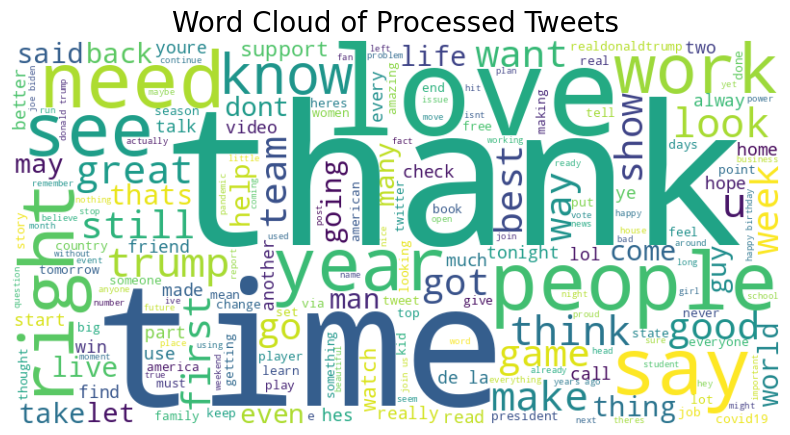

In [ ]:
all_words = ' '.join([' '.join(tweet) for tweet in train_processed['processed_tweet']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for word cloud
plt.title('Word Cloud of Processed Tweets', fontsize=20)
plt.show()

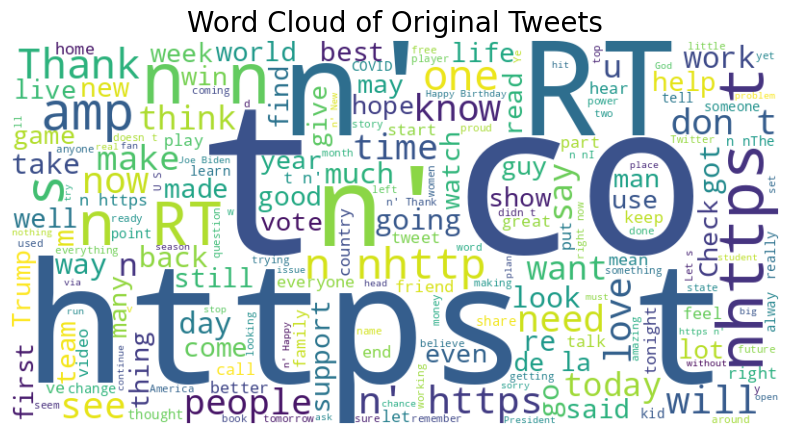

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Social Bot detection/Twibot/train.json')
# Convert each tweet to a string before joining.
# This ensures that even if a tweet contains other data types, it's treated as a string.
all_word = ' '.join([str(tweet) for tweet in df['tweet']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_word)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for word cloud
plt.title('Word Cloud of Original Tweets', fontsize=20)
plt.show()

In [ ]:
train_processed=pd.concat([train_processed,test_processed], ignore_index=True)
train_processed.to_csv('/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv', index=False)
train_processed

,label,num_links,num_hashtags,num_mentions,num_chars,processed_tweet,num_followers,num_friends,is_verified,account_age,tweet_length,statuses_count,favorites_count,listed_count,screen_name,description,friends_follower_ratio
0,0,26,13,33,2982,[ready see newest ships name thanks partners h...,15349596,692,1,12,20,9798,142,45568,SHAQ,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",0.000045
1,0,12,6,17,1741,"[thank rnc2020, great takeaways last nights re...",762839,475,1,12,20,5518,953,3201,parscale,Owner @ Parscale Strategy. Senior Advisor Digi...,0.000623
2,0,20,13,13,2901,[family fears may cheated 20000 donations rais...,327587,4801,1,12,20,192876,2946,1744,FOX13News,Bringing you the important stuff like breaking...,0.014656
3,1,12,0,13,1337,[yeah but aint got happy song nigga always dis...,13324,647,0,7,20,103,729,44,VonteThePlugNC,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,0.048559
4,0,20,0,11,1701,"[aloha welcome back space, ms tree catches fai...",12601567,96,1,11,20,4879,177,26952,SpaceX,"SpaceX designs, manufactures and launches the ...",0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9920,1,16,3,31,2561,[chicago cubs sign former texas tech reliever ...,7760,8104,0,8,20,2330,75,106,AlanReifman,Texas Tech professor of human devt and family ...,1.044330
9921,1,11,6,18,1989,[cardsfromattic gma superior graded crumbled j...,8446,408,0,3,20,50168,125825,55,CardsFromAttic,Satirizing the sports card industry one tweet ...,0.048307
9922,1,7,14,30,1674,[rt follow originalfunko chance win disney par...,309,1961,0,7,20,2950,1572,3,bkgreen09,,6.346278
9923,1,2,1,28,2011,"[run numbers buy bitcoin, imagine telling frie...",154,1019,0,8,20,152,627,0,bilalko14,,6.616883


In [ ]:
train_processed['label'].value_counts()

,count
label,
1,5922
0,4003


# Perform sentiment analysis and scale features down

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv')

columns_to_scale = ['num_chars', 'num_mentions', 'num_hashtags', 'num_links', 'account_age', 'favorites_count', 'friends_follower_ratio', 'listed_count', 'num_followers', 'num_friends', 'tweet_length', 'statuses_count']


#Use robustscaler first to scale features down to prevent outliers from affecting it
robust_scaler = RobustScaler()
df[columns_to_scale] = robust_scaler.fit_transform(df[columns_to_scale])

# Apply MinMaxScaler to bring the range to [0, 1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
df[columns_to_scale] = min_max_scaler.fit_transform(df[columns_to_scale])

df.to_csv('/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv', index=False)
df


,label,num_links,num_hashtags,num_mentions,num_chars,processed_tweet,num_followers,num_friends,is_verified,account_age,tweet_length,statuses_count,favorites_count,listed_count,screen_name,description,friends_follower_ratio
0,0,0.055556,0.004636,0.016240,0.063536,['ready see newest ships name thanks partners ...,1.259957e-01,0.000159,1,0.857143,0.1,0.001906,0.000181,0.082824,SHAQ,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",4.664524e-08
1,0,0.025641,0.002140,0.008366,0.037059,"['thank rnc2020', 'great takeaways last nights...",6.261693e-03,0.000109,1,0.857143,0.1,0.001074,0.001216,0.005818,parscale,Owner @ Parscale Strategy. Senior Advisor Digi...,6.442566e-07
2,0,0.042735,0.004636,0.006398,0.061808,['family fears may cheated 20000 donations rai...,2.688967e-03,0.001106,1,0.857143,0.1,0.037524,0.003760,0.003170,FOX13News,Bringing you the important stuff like breaking...,1.516363e-05
3,1,0.025641,0.000000,0.006398,0.028440,['yeah but aint got happy song nigga always di...,1.093688e-04,0.000149,0,0.500000,0.1,0.000020,0.000930,0.000080,VonteThePlugNC,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,5.024210e-05
4,0,0.042735,0.000000,0.005413,0.036206,"['aloha welcome back space', 'ms tree catches ...",1.034388e-01,0.000022,1,0.785714,0.1,0.000949,0.000226,0.048988,SpaceX,"SpaceX designs, manufactures and launches the ...",7.882152e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9920,1,0.034188,0.001070,0.015256,0.054554,['chicago cubs sign former texas tech reliever...,6.369723e-05,0.001867,0,0.571429,0.1,0.000453,0.000096,0.000193,AlanReifman,Texas Tech professor of human devt and family ...,1.080528e-03
9921,1,0.023504,0.002140,0.008858,0.042350,['cardsfromattic gma superior graded crumbled ...,6.932820e-05,0.000094,0,0.214286,0.1,0.009760,0.160603,0.000100,CardsFromAttic,Satirizing the sports card industry one tweet ...,4.998126e-05
9922,1,0.014957,0.004993,0.014764,0.035630,['rt follow originalfunko chance win disney pa...,2.536398e-06,0.000452,0,0.500000,0.1,0.000574,0.002006,0.000005,bkgreen09,,6.566248e-03
9923,1,0.004274,0.000357,0.013780,0.042820,"['run numbers buy bitcoin', 'imagine telling f...",1.264095e-06,0.000235,0,0.571429,0.1,0.000030,0.000800,0.000000,bilalko14,,6.846232e-03


In [ ]:
def analyze_sentiment(text):

  text = str(text) if not pd.isna(text) else ''
  scores = sia.polarity_scores(text)
  return scores

def perform_sentiment_analysis(df, text_column='processed_tweet'):

  df['sentiment_scores'] = df[text_column].apply(lambda tweets: analyze_sentiment(" ".join(tweets)) if isinstance(tweets, list) else analyze_sentiment(tweets))
  df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])
  df['sentiment_category'] = df['compound_sentiment'].apply(lambda score:
        'Positive' if score >= 0.05 else
        'Negative' if score <= -0.05 else
        'Neutral'
  )
  return df


df = perform_sentiment_analysis(df)



In [ ]:
df

,label,num_links,num_hashtags,num_mentions,num_chars,processed_tweet,num_followers,num_friends,is_verified,account_age,tweet_length,statuses_count,favorites_count,listed_count,screen_name,description,friends_follower_ratio,sentiment_scores,compound_sentiment,sentiment_category
0,0,0.055556,0.004636,0.016240,0.063536,['ready see newest ships name thanks partners ...,1.259957e-01,0.000159,1,0.857143,0.1,0.001906,0.000181,0.082824,SHAQ,"VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...",4.664524e-08,"{'neg': 0.032, 'neu': 0.598, 'pos': 0.37, 'com...",0.9990,Positive
1,0,0.025641,0.002140,0.008366,0.037059,"['thank rnc2020', 'great takeaways last nights...",6.261693e-03,0.000109,1,0.857143,0.1,0.001074,0.001216,0.005818,parscale,Owner @ Parscale Strategy. Senior Advisor Digi...,6.442566e-07,"{'neg': 0.11, 'neu': 0.672, 'pos': 0.217, 'com...",0.9725,Positive
2,0,0.042735,0.004636,0.006398,0.061808,['family fears may cheated 20000 donations rai...,2.688967e-03,0.001106,1,0.857143,0.1,0.037524,0.003760,0.003170,FOX13News,Bringing you the important stuff like breaking...,1.516363e-05,"{'neg': 0.106, 'neu': 0.735, 'pos': 0.159, 'co...",0.9752,Positive
3,1,0.025641,0.000000,0.006398,0.028440,['yeah but aint got happy song nigga always di...,1.093688e-04,0.000149,0,0.500000,0.1,0.000020,0.000930,0.000080,VonteThePlugNC,MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...,5.024210e-05,"{'neg': 0.08, 'neu': 0.671, 'pos': 0.249, 'com...",0.9852,Positive
4,0,0.042735,0.000000,0.005413,0.036206,"['aloha welcome back space', 'ms tree catches ...",1.034388e-01,0.000022,1,0.785714,0.1,0.000949,0.000226,0.048988,SpaceX,"SpaceX designs, manufactures and launches the ...",7.882152e-09,"{'neg': 0.013, 'neu': 0.895, 'pos': 0.092, 'co...",0.9274,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9920,1,0.034188,0.001070,0.015256,0.054554,['chicago cubs sign former texas tech reliever...,6.369723e-05,0.001867,0,0.571429,0.1,0.000453,0.000096,0.000193,AlanReifman,Texas Tech professor of human devt and family ...,1.080528e-03,"{'neg': 0.006, 'neu': 0.734, 'pos': 0.26, 'com...",0.9972,Positive
9921,1,0.023504,0.002140,0.008858,0.042350,['cardsfromattic gma superior graded crumbled ...,6.932820e-05,0.000094,0,0.214286,0.1,0.009760,0.160603,0.000100,CardsFromAttic,Satirizing the sports card industry one tweet ...,4.998126e-05,"{'neg': 0.081, 'neu': 0.735, 'pos': 0.185, 'co...",0.9712,Positive
9922,1,0.014957,0.004993,0.014764,0.035630,['rt follow originalfunko chance win disney pa...,2.536398e-06,0.000452,0,0.500000,0.1,0.000574,0.002006,0.000005,bkgreen09,,6.566248e-03,"{'neg': 0.033, 'neu': 0.575, 'pos': 0.392, 'co...",0.9972,Positive
9923,1,0.004274,0.000357,0.013780,0.042820,"['run numbers buy bitcoin', 'imagine telling f...",1.264095e-06,0.000235,0,0.571429,0.1,0.000030,0.000800,0.000000,bilalko14,,6.846232e-03,"{'neg': 0.179, 'neu': 0.71, 'pos': 0.111, 'com...",-0.9506,Negative
